In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import math
import matplotlib.pyplot as plt

# Cargar los datos
data = pd.read_csv('Wind_Data.csv')
data.head()


,dia,regional wind,wind gap norte sur
0,1,8.000000,0.000000
1,2,8.346296,0.181523
2,3,10.062316,0.188643
3,4,10.791337,0.071085
4,5,10.754093,0.078442


In [2]:
def daily_dif(current_wind, previous_wind):
    # Calcular el incremento como la diferencia entre los vientos
    return (current_wind - previous_wind)

# Calcular incremento diario
data['wind_increase'] = daily_dif(data['regional wind'], data['regional wind'].shift(1))
data.head()


,dia,regional wind,wind gap norte sur,wind_increase
0,1,8.000000,0.000000,NaN
1,2,8.346296,0.181523,0.346296
2,3,10.062316,0.188643,1.716019
3,4,10.791337,0.071085,0.729021
4,5,10.754093,0.078442,-0.037244


In [3]:
# Definir delta
delta = 1/365

# Definir la θ(t)
def theta(i):
    return 6 + 2 * math.cos(2*math.pi * (i-1)/365)

# Calcular θ(t) para cada día
data['theta'] = data['dia'].apply(theta)
data.head()


,dia,regional wind,wind gap norte sur,wind_increase,theta
0,1,8.000000,0.000000,NaN,8.000000
1,2,8.346296,0.181523,0.346296,7.999704
2,3,10.062316,0.188643,1.716019,7.998815
3,4,10.791337,0.071085,0.729021,7.997334
4,5,10.754093,0.078442,-0.037244,7.995261


In [14]:
s_i = data['regional wind'].shift(1)
theta = data['theta']
X = ((theta - s_i) * delta)[1:].values
Y = (data['wind_increase'])[1:].values

# Modelo de regresión lineal
reg = LinearRegression().fit(X.reshape(-1, 1), Y)

# Predicciones y error
Y_pred = reg.predict(X.reshape(-1, 1))
error = Y - Y_pred

# Cálculo de kappa y sigma con error de estimación
kappa = reg.coef_[0]
c = np.sqrt(error.var())
sigma = c / np.sqrt(delta)

# Error estándar de σ
sigma_error = sigma / np.sqrt(len(error))

# Error estándar de kappa
kappa_error = np.sqrt(np.sum((error - np.mean(error))**2) / (len(error) - 2)) / np.sqrt(np.sum(X**2))

print(f"κ: {kappa}, Error de κ: {kappa_error}")
print(f"σ: {sigma}, Error de σ: {sigma_error}")



κ: 109.04125628331585, Error de κ: 4.294413913397189
σ: 16.04457314539312, Error de σ: 0.26560805146180083


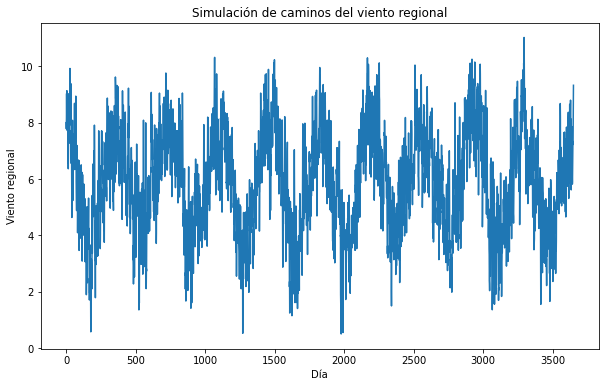

In [15]:
# función para simular caminos de viento
def wind_paths(S_0, kappa, theta, sigma, delta, T):
    S = np.full(T, S_0)
    for t in range(1, T):
        S[t] = S[t-1] + kappa * (theta[t] - S[t-1]) * delta + np.sqrt(delta) * np.random.normal(0,1) * sigma
    return S

# innit
S_0 = data['regional wind'].iloc[0]
T = 365 * 10

# Simulamos
S = wind_paths(S_0, kappa, theta, sigma, delta, T)

# Graficamos
plt.figure(figsize=(10, 6))
plt.plot(S)
plt.title('Simulación de caminos del viento regional')
plt.xlabel('Día')
plt.ylabel('Viento regional')
plt.show()


In [18]:
# Creamos 'gap_dif' como la diferencia diaria del gap del viento entre el norte y sur
data['gap_dif'] = data['wind gap norte sur'] - data['wind gap norte sur'].shift(1)
data.head()

# Definimos variables para wind gap
Y_gap = (data['gap_dif'])[1:].values
d_i = data['wind gap norte sur'].shift(1)
X_gap = (d_i * delta)[1:].values

# Ajustar el modelo de regresión lineal para el wind gap
reg_gap = LinearRegression().fit(X_gap.reshape(-1, 1), Y_gap)

# Predecimos y calculamos error
Y_pred_gap = reg_gap.predict(X_gap.reshape(-1, 1))
error_gap = Y_gap - Y_pred_gap

# Cálculo de beta y gamma y su error de estimación
beta = -(reg_gap.coef_[0])
gamma = np.sqrt(error_gap.var()) / np.sqrt(delta)

# Error estándar de gamma
gamma_error = gamma / np.sqrt(len(error_gap))

# Error estándar de beta
beta_error = np.sqrt(np.sum((error_gap - np.mean(error_gap))**2) / (len(error_gap) - 2)) / np.sqrt(np.sum(X_gap**2))

print(f"β: {beta}, Error de β: {beta_error}")
print(f"γ: {gamma}, Error de γ: {gamma_error}")

β: 48.37733323194377, Error de β: 3.0057533121947224
γ: 10.090719957138331, Error de γ: 0.1670456696712918
